# Import packages and define global variables and functions

In [18]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection
from matplotlib.patches import Ellipse

In [3]:
os.chdir("/Users/shahdelnaggar/Desktop/korem-lab/south-africa-ESCC/ESCC_microbiome_16S_analysis")

In [4]:
def sdi(counts):
    """ Given a list of counts, returns the Shannon Diversity Index (SDI) """
    from math import log as ln
    def p(n, N):
        """ Relative abundance """
        if n == 0:
            return 0
        else:
            return (float(n) / N) * ln(float(n) / N)   
    N = sum(counts)
    return -sum(p(n, N) for n in counts if n != 0)

# def plot_taxa_boxplot(feature_table,taxa):
#     cancer = feature_table[]
#     my_pal = {"0": "#00AEEF", "1": "#BE1E2D"}
#     sns.set_theme(style="white", palette=None)
#     sns.set_style("ticks")
#     fig, ax = plt.subplots(figsize=(2, 3))
#     sns.boxplot(x=feature_table["Cancer"], y=feature_table[ASV].apply(lambda x:np.log10(x + 1e-4)),fliersize=2,linewidth=1.4,palette=my_pal)
#     sns.swarmplot(x=feature_table["Cancer"], y=feature_table[ASV].apply(lambda x:np.log10(x + 1e-4)),color="black",s=4)
#     ax.set_ylabel("log10(Relative Abundance)")
#     ax.set_ylim(-4.0,0.00)
#     ax.set_xlabel("")
#     ax.tick_params(labelsize=12,bottom=False)
#     ax.set_xticklabels(['Control', 'ESCC'], size=15)
#     ax.set_title("AMR gene (S2)", size=15, fontweight='bold')
#     ax.set_title("Fusobacterium sp HMT 204 (10567))")
#     # plt.savefig(f"/Users/shahdelnaggar/Desktop/korem-lab/south-africa-ESCC/figures/{ASV}.svg")
#     plt.show()

In [5]:
feature_table = pd.read_csv("data/feature_table_decontaminated.csv",index_col=0).T
rarefied_table = pd.read_csv("data/feature_table_filtered_rarefied.csv",index_col=0).T # taxa in at least 5 samples, total count of 20, rarefied to minimum sampling depth (9700 reads)
taxonomy = pd.read_csv("data/homd-taxonomy.csv", index_col=0)

In [6]:
feature_ra = feature_table.div(feature_table.sum(axis=1),axis=0)
feature_ra["Cancer"] = [int("CESCC" in sample_id) for sample_id in feature_ra.index]
feature_ra.sort_index(inplace=True)

# Diversity metrics

## Fig 1a. Alpha Diversity 

/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 5.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/var/folders/3_/1cj9ly452_bgpshkny7139pr0000gn/T/ipykernel_89288/204478293.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Control', 'ESCC'], size=15)
/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 8.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


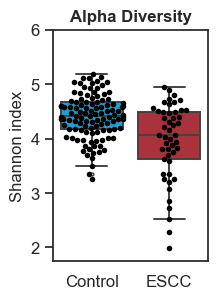

P value = 0.00020662024615608068


In [25]:
shannon_index = pd.DataFrame(data = rarefied_table.apply(sdi,axis=1),columns=["shannon"])
shannon_index["Cancer"] = [int("CESCC" in name) for name in shannon_index.index]

x = shannon_index["Cancer"].astype(str)
y = shannon_index["shannon"]


my_pal = {"0": "#00AEEF", "1": "#BE1E2D"}
sns.set_theme(style="white", palette=None)
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(2, 3))
sns.boxplot(x=x,y=y,fliersize=2,linewidth=1.4, hue = x, palette=my_pal)
sns.swarmplot(x=x,y=y,color="black",s=4)
ax.set_ylabel("Shannon index")
ax.set_ylim(1.75,6)
ax.set_xlabel("")
ax.set_xticklabels(['Control', 'ESCC'], size=15)
ax.tick_params(labelsize=12,bottom=False)
ax.set_title("Alpha Diversity", size=12, fontweight='bold')

plt.show()

stat,p_value = stats.mannwhitneyu(shannon_index.loc[shannon_index["Cancer"] == 1,"shannon"],shannon_index.loc[shannon_index["Cancer"] == 0,"shannon"],alternative='two-sided')
print(f"P value = {p_value}")

## Fig 1b. Beta Diversity (Unweighted)

In [26]:
def plot_point_cov(points, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma ellipse based on the mean and covariance of a point
    "cloud" (points, an Nx2 array).

    Parameters
    ----------
        points : An Nx2 array of the data points.
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    pos = points.mean(axis=0)
    cov = np.cov(points, rowvar=False)
    return plot_cov_ellipse(cov, pos, nstd, ax, **kwargs)

def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip

In [55]:
unweighted_pcoa = pd.read_csv('diversity/unweighted_unifrac_pcoa_ordination.txt',sep='\t',skiprows=6,index_col=0)
unweighted_pcoa["Cancer"] = [int("CESCC" in name) for name in unweighted_pcoa.index]
unweighted_pctvar=pd.read_csv('diversity/unweighted_unifrac_pcoa_ordination.txt',sep='\t').iloc[3,:]

/var/folders/3_/1cj9ly452_bgpshkny7139pr0000gn/T/ipykernel_89288/2740797025.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pc1_percentage = float(unweighted_pctvar[0]) * 100
/var/folders/3_/1cj9ly452_bgpshkny7139pr0000gn/T/ipykernel_89288/2740797025.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pc2_percentage = float(unweighted_pctvar[1]) * 100


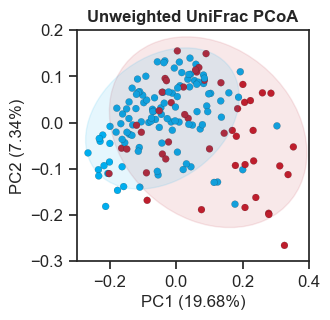

In [71]:
my_pal = {0: "#00AEEF", 1: "#BE1E2D"}
fig, ax = plt.subplots(figsize=(3, 3))

ax = sns.scatterplot(x="158", y="158.1", hue="Cancer", data=unweighted_pcoa, 
                     palette=my_pal, s=25, edgecolor='black',linewidth=0.1)
    
points_cancer_1 = unweighted_pcoa[unweighted_pcoa["Cancer"] == 1][["158", "158.1"]].values
e1 = plot_point_cov(points_cancer_1, nstd=2, ax=ax)
e1.set_facecolor((190/255, 30/255, 45/255, 0.1))
e1.set_edgecolor((190/255, 30/255, 45/255, 0.1))

points_cancer_0 = unweighted_pcoa[unweighted_pcoa["Cancer"] == 0][["158", "158.1"]].values
e2 = plot_point_cov(points_cancer_0, nstd=2, ax=ax)
e2.set_facecolor((0, 174/255, 239/255, 0.1))
e2.set_edgecolor((0, 174/255, 239/255, 0.1)) 

pc1_percentage = float(unweighted_pctvar[0]) * 100
pc2_percentage = float(unweighted_pctvar[1]) * 100

ax.set_xlabel(f"PC1 ({pc1_percentage:.2f}%)")
ax.set_ylabel(f"PC2 ({pc2_percentage:.2f}%)")

ax.set_ylim(-0.3, 0.20)
ax.set_xlim(-0.3, 0.40)

ax.set_title("Unweighted UniFrac PCoA", size=12, fontweight='bold')
ax.tick_params(labelsize=12)
ax.legend([], [], frameon=False)

plt.show()


## Supplementary Fig 1. Beta Diversity (Weighted) 

In [72]:
weighted_pcoa = pd.read_csv('diversity/weighted_unifrac_pcoa_ordination.txt',sep='\t',skiprows=6,index_col=0)
weighted_pcoa["Cancer"] = [int("CESCC" in name) for name in weighted_pcoa.index]
weighted_pctvar=pd.read_csv('diversity/weighted_unifrac_pcoa_ordination.txt',sep='\t').iloc[3,:]

/var/folders/3_/1cj9ly452_bgpshkny7139pr0000gn/T/ipykernel_89288/3916453876.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pc1_percentage = float(weighted_pctvar[0]) * 100
/var/folders/3_/1cj9ly452_bgpshkny7139pr0000gn/T/ipykernel_89288/3916453876.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pc2_percentage = float(weighted_pctvar[1]) * 100


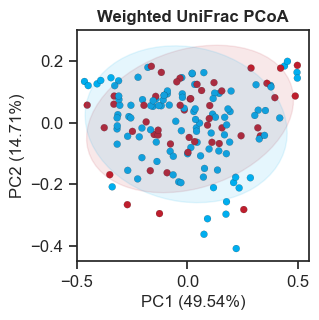

In [79]:
my_pal = {0: "#00AEEF", 1: "#BE1E2D"}
fig, ax = plt.subplots(figsize=(3, 3))

ax = sns.scatterplot(x="158", y="158.1", hue="Cancer", data=weighted_pcoa, 
                     palette=my_pal, s=25, edgecolor='black',linewidth=0.1)
    
points_cancer_1 = weighted_pcoa[weighted_pcoa["Cancer"] == 1][["158", "158.1"]].values
e1 = plot_point_cov(points_cancer_1, nstd=2, ax=ax)
e1.set_facecolor((190/255, 30/255, 45/255, 0.1))
e1.set_edgecolor((190/255, 30/255, 45/255, 0.1))

points_cancer_0 = weighted_pcoa[weighted_pcoa["Cancer"] == 0][["158", "158.1"]].values
e2 = plot_point_cov(points_cancer_0, nstd=2, ax=ax)
e2.set_facecolor((0, 174/255, 239/255, 0.1))
e2.set_edgecolor((0, 174/255, 239/255, 0.1)) 

pc1_percentage = float(weighted_pctvar[0]) * 100
pc2_percentage = float(weighted_pctvar[1]) * 100

ax.set_xlabel(f"PC1 ({pc1_percentage:.2f}%)")
ax.set_ylabel(f"PC2 ({pc2_percentage:.2f}%)")

ax.set_ylim(-0.45, 0.3)
ax.set_xlim(-0.5, 0.55)

ax.set_title("Weighted UniFrac PCoA", size=12, fontweight='bold')
ax.tick_params(labelsize=12)
ax.legend([], [], frameon=False)

plt.show()


# Differential abundance

## Fig 2a. Genus level differential abundance

## Fig 2b. ASV level differential abundance

## Fig 2c. Fusobacterium differential abundance

# Predictive models 

## Fig 3a. Validation of predictors on held-out samples 

## Fig 3b. Microbiome model feature importance 

## Supplementary Fig 2a. Clinical model feature importance

## Supplementary Fig 2b. Combined model feature importance

## Fig 3c. Validation of microbiome predictor on external cohort 